In [85]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import scipy.constants as sc
from scipy.fft import fft,ifft,fftfreq, dct, idct
import matplotlib.pyplot as plt
from numpy import linalg as LA
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
import mpl_toolkits.mplot3d as mplot3d
import scipy.special as ss
from scipy.integrate import quad, dblquad
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
nu_and_nu_d_data = pd.read_csv("C:\\Users\\david\\Documents\\data for fig5b from flattened BEC paper.csv", header = None)

In [ ]:
class split_step_method():
    def __init__(self,N,Nz,gamma_sin,box,
                 b = 25, use_cosine_transform = False,
                 quasi_2D = False, Hankel_3D_without_cosine = False,
                 box_potential=False,
                 get_nu_stability_boundary=False,
                 purely_dipolar_stability=False,
                 get_single_plot=False,
                 
                 
                 gs = 0, ##dimensionless contact factor
                 D_sin = 0,N_iterations=5000,

                 m = 2.7774e-25, ##mass of erbium atom
                 w=100*np.pi, ##radial frequency
                 Ao = 5.29*1e-11, #Bohr radius
                 
                 mu =6.98, ##dipole moment of erbium
                 mu_B =9.2740100783e-24, ##Bohr magneton
                 
                 No = 4.5*1e4, #number of particles
                 ):
        
        for local in locals().copy(): 
            ## equivalent of writing self.gamma = gamma,self.b = b etc.
            ## without having to rewrite it.
            exec('self.' + local +  ' = locals()[local]')
        
        if self.use_cosine_transform + self.quasi_2D + self.Hankel_3D_without_cosine > 1: 
            raise AttributeError('Can only do one from Quasi, Cosine or full 3D.')
        if self.purely_dipolar_stability + self.get_nu_stability_boundary + get_single_plot >1:
            raise AttributeError('Can only do one from stability for purely dipolar, stability for contact and dipolar, and single plot.')
        if self.use_cosine_transform:
            print("Doing Hankel with Cosine transform")
        if self.Hankel_3D_without_cosine:
            print("Doing Hankel without Cosine transform")
        if self.quasi_2D:
            print("Doing Quasi 2D")
        if self.box_potential:
            print("with a circular box potential in the r direction")
        else:
            print("with a harmonic potential in the r direction")
            
            
        self.initialise_variables() ## variables not dependent on gamma
        
        if get_single_plot:
                
            self.update_variables_based_on_gamma()

            self.psi,self.E_list,self.E_index_list = self.split_step_method_loop()

            self.plot_results_from_split_step_method(self.psi,self.E_list,self.E_index_list)
        
        if get_nu_stability_boundary:
           
            self.stability_boundary_nu_values,self.stability_boundary_nu_dipole_values = self.get_stability_boundary_loop()
            
            self.plot_results_from_stability_boundary_code(self.stability_boundary_nu_values,
                                                           self.stability_boundary_nu_dipole_values)
        
        if purely_dipolar_stability:
            self.stability_matrix,self.stability_boundary_D_values,self.stability_boundary_gamma_values,self.ground_state_energy_values = self.split_step_method__stability_code()
            
            self.plot_results_from_stability_code(self.stability_matrix,
                                                  self.stability_boundary_D_values,
                                                  self.stability_boundary_gamma_values,
                                                  self.ground_state_energy_values)
            
            
        
                
                
    
    def plot_results_from_split_step_method(self,psi,E_list,E_index_list,):
        #if z_cutoff is None: z_cutoff = np.max(np.abs(self.z)/2)
        
        z_cutoff = np.max(np.abs(self.z))#np.max(np.abs(self.z)/2)
        
        if not self.box_potential:
            r_cutoff = 20
            z_cutoff = np.max(np.abs(self.z))/2
        else:
            r_cutoff = self.b ##for box plot, can plot all of r
            z_cutoff = np.max(np.abs(self.z))
        
        diff = psi - self.gnd_state
        
        plt.plot(np.asarray(E_index_list),np.asarray(E_list))
        plt.xlabel('iteration number')
        plt.ylabel('energy')
        plt.show()
        
        if self.quasi_2D:
            plt.plot(self.r,psi, label ="numerical ground state")
            plt.plot(self.r,self.gnd_state,'r--', label ="true ground state")
            #plt.plot(r,TF_dipolar,'m--',label = "Dipolar Thomas Fermi solution")
            #plt.plot(r,TF_contact,'g--',label = "Contact Thomas Fermi solution")
            plt.legend()
            plt.xlabel('r/xs')
            plt.ylabel('psi')
            #plt.ylim(0,20)
            #plt.xlim(0,10)
            plt.show()
    
            plt.plot(self.r,100*diff/np.max(psi),label="diff in % of max psi")
            plt.xlabel('r position')
            plt.ylabel('diff/% of max of psi')
            #plt.ylim(-1,1)
            plt.xlim(0,10)
            plt.legend()
            plt.title('diff/%')
            plt.show() # plots psi against x
        
           
        else:
            fig,ax = plt.subplots()
            ax.contour(self.r,self.z,np.abs(psi))
            ax.set_title('contour plot of psi')
            #ax.set_ylim(-1,1)
            #ax.set_xlim(0,box)
            ax.set_xlabel('r position')
            ax.set_ylabel('z position')
            plt.show()
        
            bools =(np.abs(self.r) <= r_cutoff)*(np.abs(self.z) <=z_cutoff)
            ##boolean vector used to manually set limits on the axes
            
        if self.use_cosine_transform:
            n_1 = np.sum(bools[:,self.Nz-1]) ## number of r coords with value less than r_cutoff
            n_2 = self.Nz - np.sum(bools[0,:]) ## number of z coords with value less than z_cutoff
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_surface(self.r[0:n_1,n_2:(self.Nz-1)],
                                self.z[0:n_1,n_2:(self.Nz-1)],
                                np.abs(psi)[0:n_1,n_2:(self.Nz-1)],cmap='jet')
            ax.set_title('Psi')
            ax.set_xlabel('r position')
            ax.set_ylabel('z position')
            ax.set_zlabel('psi')
            plt.show()
            
            plt.plot(self.r[:,0],np.abs(psi[:,self.Nz-1]),label="numerical solution, z=0")
            plt.plot(self.r[:,0],self.gnd_state[:,self.Nz-1],label="true solution, z=0")
            #plt.plot(self.r[:,0],TF_contact[:,self.Nz-1], label="Thomas Fermi for contact, z=0")
            #plt.plot(self.r[:,0],TF_quasi[:,self.Nz-1], label="Thomas Fermi for purely dipolar, z=0")
            plt.title('psi in z=0 plane')
            #plt.xlim(10,20)
            plt.legend()
            plt.xlabel('r position')
            plt.ylabel('psi')
            plt.show()        

            plt.plot(self.z[0,:],np.abs(np.rot90(psi,k=3))) ##rotating 270 degrees
            plt.plot(self.z[0,:],np.abs(self.gnd_state[0,:]),label = "ground state, r=0")
            #plt.plot(z(gamma)[0,:],np.abs(TF_contact[0,:]),label="Thomas Fermi for contact,z=0")
            plt.title('psi in z direction, r=0')
            #plt.xlim(0,5)
            plt.legend()
            plt.xlabel(' z position')
            plt.ylabel('psi')
            plt.show()  

            plt.plot(self.r[:,0],100*diff[:,self.Nz-1]/np.max(psi),label="diff in r direction, z=0")
            plt.plot(self.z[0,:],100*diff[0,:]/np.max(psi),label="diff in z direction, r=0")
            plt.title('diff/% of psi for r=0 and z=0 to ground state with no interactions')
            #plt.xlim(0,6)
            plt.xlabel('r,z')
            plt.ylabel('difference in % of max psi"')
            plt.legend()
            plt.show()  

        if self.Hankel_3D_without_cosine:
            n_1 = np.sum(bools[:,self.midway_index_z]) ## number of r coords with value less than r_cutoff
            n_2 = np.sum(bools[0,:]) ## number of z coords with value less than z_cutoff            
            z_coord_i = int(self.midway_index_z-n_2/2)
            z_coord_f = int(self.midway_index_z+n_2/2)
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_surface(self.r[0:n_1,z_coord_i:z_coord_f],
                            self.z[0:n_1,z_coord_i:z_coord_f],
                            np.abs(psi)[0:n_1,z_coord_i:z_coord_f],
                            cmap='jet')
            ax.set_title('Psi')
            ax.set_xlabel('r position')
            ax.set_ylabel('z position')
            ax.set_zlabel('psi')
            plt.show()
            
            plt.plot(self.r[:,0],np.abs(psi[:,self.midway_index_z]),label="numerical solution, z=0")
            plt.plot(self.r[:,0],self.gnd_state[:,self.midway_index_z],label="true solution, z=0")
            #plt.plot(r[:,0],TF_contact[:,midway_index_z], label = "Thomas Fermi, z=1")
            #plt.plot(r[:,0],TF_quasi[:,midway_index_z], label = "Thomas Fermi, z=0")
            plt.title('psi in z=0 plane')
            plt.xlim(0,r_cutoff)
            plt.legend()
            plt.xlabel('r position')
            plt.ylabel('psi')
            plt.show()        

            plt.plot(self.z[0,:],np.abs(np.rot90(psi)))
            plt.plot(self.z[0,:],np.abs(self.gnd_state[0,:]),label = "ground state, r=0")
            plt.title('psi in z direction, r=0')
            plt.xlim(0,r_cutoff)
            plt.legend()
            plt.xlabel(' z position')
            plt.ylabel('psi')
            plt.show()  

            plt.plot(self.r[:,0],100*diff[:,self.midway_index_z]/np.max(psi),label="diff in r direction, z=0")
            plt.plot(self.z[0,:],100*diff[0,:]/np.max(psi),label="diff in z direction, r=0")
            plt.title('diff/% of psi for r=0 and z=0 to ground state with no interactions')
            plt.xlabel('r,z')
            plt.ylabel('difference in % of max psi"')
            plt.legend()
            plt.show()  

    def plot_results_from_stability_code(self,stability_matrix,boundary_D_values,boundary_gamma_values,Energy_values):
        
        gamma_values = np.asarray(boundary_gamma_values)
        D_values = np.asarray(boundary_D_values)
        #####need to get data from paper that equates to the purely dipolar case

        plt.plot(gamma_values,D_values,label= 'stability boundary for $g_{s}$ ='+str(0))
        plt.xlabel('$\gamma$')
        plt.ylabel('D')
        plt.grid()
        plt.legend()
        #plt.xlim(0,self.nu_range)
        #plt.ylim(0,self.nu_d_range)
        plt.show()

        rounded_Ds = np.round(self.Ds,1)
        rounded_gammas = np.round(self.gammas,1)
        df = pd.DataFrame(np.rot90(stability_matrix),index = np.max(rounded_Ds)-rounded_Ds,columns=rounded_gammas)
        sns.heatmap(df)
        plt.xlabel('$\gamma$')
        plt.ylabel('D')
        plt.show()
        
        
        Ds_2D = self.Ds.reshape(1,-1).repeat(self.gamma_res,0)
        gammas_2D = self.gammas.reshape(-1,1).repeat(self.D_res,1)

        df2 = pd.DataFrame(np.rot90(Energy_values),index = np.max(rounded_Ds)-rounded_Ds,columns=rounded_gammas)
        sns.heatmap(df2)
        plt.xlabel('$\gamma$')
        plt.ylabel('D')
        plt.show()

        
        plt.plot(Ds_2D[int(self.gamma_res/2),:],
                 Energy_values[int(self.gamma_res/2),:],
                 label='Energy for gamma ='+str(gammas_2D[0,int(self.gamma_res/2)]) + 'unstable regions are given E=0' )
        plt.grid()
        plt.legend()
        plt.xlabel('D')
        plt.ylabel('E/$\hbar\omega_{z}')
        plt.show()
        
        
    
    def plot_results_from_stability_boundary_code(self,nu_values,nu_d_values):
        #nu_values = np.asarray(nu_values)
        #nu_d_values = np.asarray(nu_d_values)
        nu_and_nu_d_data = pd.read_csv("C:\\Users\\david\\Documents\\data for fig5b from flattened BEC paper.csv", header = None)
        nu_and_nu_d_data = nu_and_nu_d_data.values
        
#         nu_values[nu_values==0] = np.max(nu_values)
#         nu_d_values[nu_d_values==0] = np.max(nu_d_values)
#         nu_values[:,0] = 0 
#         nu_d_values[:,0] = 0
        
        
        
        plt.plot(nu_and_nu_d_data[0,:],nu_and_nu_d_data[1,:])
        plt.plot(np.transpose(nu_values),nu_d_values[0,:])

        plt.xlabel('nu')
        plt.ylabel('nu_d')
        plt.grid()
        plt.legend(np.append('Data from Paper',['gamma = '+str(s) for s in self.gammas_for_nu_boundary]))
        plt.xlim(0,self.nu_range)
        plt.ylim(0,self.nu_d_range)
        plt.show()

            
     
    def split_step_method_loop(self,):
        
        self.initialise_psi()
        psi = self.psi.copy() ##so you don't need to keep writing self for psi
        E_list = []
        E_index_list = []
        
        exp_T = self.initialise_exp_T(E_list,)
        #self.split_step_method_dt_trig = False
        trig = False
        dt = self.dt(E_list)
        for i in tqdm_notebook(range(self.N_iterations),leave = False,
                              desc = 'Iterating over Imaginary Time'):  ##split step loop
            
            if i%10==0:
                E_list.append([self.ENERGY(psi,self.gamma,self.gs,self.J)])
                E_index_list.append([i])
                
                exp_T = self.initialise_exp_T(E_list,)
                if not trig:
                #if not self.split_step_method_dt_trig:
                    new_dt = self.dt(E_list)
                    #self.split_step_method_dt_trig = (abs(new_dt) < abs(dt)) ###once dt drops, it stays there
                    trig = abs(new_dt) < abs(dt)
                    dt = new_dt
                                
            if self.quasi_2D:
                psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                psi = exp_T*self.do_Hankel_transform(psi,self.J) ## applies kinetic in (cosine) fourier and bessel space
                psi = self.do_inverse_Hankel_transform(psi,self.J)  ##transforms back to position space
                psi /= self.Norm_r(psi)
                psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                psi /= self.Norm_r(psi)
                
            if self.use_cosine_transform:   
                psi = np.exp(-0.5j*dt*self.V(psi,J=self.J,gs=self.gs))*psi ##applies s\econd half of potential
                psi = exp_T*self.do_Hankel_transform(dct(psi,1,axis=1),self.J) ## applies kinetic in (cosine) fourier and bessel space   
                psi = idct(self.do_inverse_Hankel_transform(psi,self.J),1,axis=1)  ##transforms back to position space
                #########################################
                ##discrepancy between codes here, but very small
                ##########################################
                psi /= self.Norm_r(psi)
                psi = np.exp(-0.5j*dt*self.V(psi,J=self.J,gs=self.gs))*psi ##applies second half of potential              
                psi /= self.Norm_r(psi)
                #if self.E_conv(E_list,criteria=1e-3): ##unsure if this is needed
                if (psi[0,self.Nz-1]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                    print('not converged')
                    break
                
            if self.Hankel_3D_without_cosine:
                psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies half the potential
                psi = exp_T*self.do_Hankel_transform(fft(psi,axis=1),self.J) ##applies kinetic in k space
                psi = ifft(self.do_inverse_Hankel_transform(psi,self.J),axis=1) ##transforms back to position space
                psi /= self.Norm_r(psi) ##normalising, needs to be right normalisation for psi dependent V
                psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                psi /= self.Norm_r(psi) ##normalises
                #if self.E_conv(E_list,criteria=1e-3):
                if (psi[0,self.midway_index_z]/np.max(psi))<0.01:###breaks if there is a spike away from origin
                    print('not converged')
                    break
            
            if np.isnan(psi).any() or np.min(E_list)<0: #or np.max(E_list)>E_list[0]: 
                print('not converged')    
                break ##stops the loop early if there is a collapse to nan or energy becomes negative,
                        ###or if energy becomes larger than the initial guess (spike)
            
            if self.E_conv(E_list,criteria=1e-8): 
                print('converged')
                break
            #####################################################
        return psi,E_list,E_index_list

    def split_step_method__stability_code(self,p_max = 10000):
        #####could set p_max to be a function of gamma?
        
        
        
        
        if not self.box_potential:
            self.D_range = 180
            self.gamma_range_start = 1
            self.gamma_range_end = 18
            self.D_res = 81
            self.gamma_res = 81
        #elif not self.get_stability_boundary_purely_dipolar:
        else:    
            self.D_range = 100
            self.gamma_range_start = 1
            self.gamma_range_end = 30
            self.D_res = 101
            self.gamma_res =101
#         else:
#             self.D_range = 180
#             self.gamma_range_start = 1
#             self.gamma_range_end = 40
#             self.D_res = 81
#             self.gamma_res =81
            
            
            
        self.Ds = np.linspace(0,self.D_range,self.D_res)
        self.gammas = np.linspace(self.gamma_range_start,self.gamma_range_end,self.gamma_res)
        stability_matrix = np.zeros([self.gamma_res,self.D_res])
        self.final_Energy_matrix = np.zeros([self.gamma_res,self.D_res])
        self.final_psi_list = []
        
        stability_boundary_reached = False
        #if self.get_stability_boundary_purely_dipolar:
        stability_boundary_gamma_values = []
        stability_boundary_D_values = []
        for i in tqdm_notebook(range(self.gamma_res),leave = False,
                              desc = 'Iterating over gamma'):
            stability_boundary_reached = False
            self.gamma = self.gammas[i]
            self.update_variables_based_on_gamma()
            ######
            ######
            
            #for j in tqdm_notebook(range(self.D_res),leave=False,
             #                     desc = 'Iterating over D'):
            for j in range(self.D_res):  
                if stability_boundary_reached:
                    break
                self.D = self.Ds[j] ##iterates through different values of D and gamma
                self.initialise_psi() ##sets initial guess
                psi = self.psi.copy()
                
                E_list = []
                isConv=False
                p=0
                exp_T = self.initialise_exp_T(E_list,)
                self.split_step_method_dt_trig = False
                dt = self.dt(E_list)
                while not isConv and p<p_max: ##loops until convergence or p=p_max
                    if p%10==0:
                        E_list.append(self.ENERGY(psi,gamma = self.gamma,gs=self.gs,J=self.J))
                        exp_T = self.initialise_exp_T(E_list)
                        if not self.split_step_method_dt_trig:
                            new_dt = self.dt(E_list)
                            self.split_step_method_dt_trig = (abs(new_dt)<abs(dt))
                            dt = new_dt
                    if self.quasi_2D:
                        psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                        psi = exp_T*self.do_Hankel_transform(psi,self.J) ## applies kinetic in (cosine) fourier and bessel space
                        psi = self.do_inverse_Hankel_transform(psi,self.J)  ##transforms back to position space
                        psi /= self.Norm_r(psi)
                        psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                        psi /= self.Norm_r(psi)
                        
                    if self.use_cosine_transform:   
                        psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                        psi = exp_T*self.do_Hankel_transform(dct(psi,1,axis=1),self.J) ## applies kinetic in (cosine) fourier and bessel space
                        psi = idct(self.do_inverse_Hankel_transform(psi,self.J),1,axis=1)  ##transforms back to position space
                        psi /= self.Norm_r(psi)
                        psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                        psi /= self.Norm_r(psi)
                        if (psi[0,self.Nz-1]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                            isConv = True
                
                    if self.Hankel_3D_without_cosine:
                        psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies half the potential
                        psi = exp_T*self.do_Hankel_transform(fft(psi,axis=1),self.J) ##applies kinetic in k space
                        psi = ifft(self.do_inverse_Hankel_transform(psi,self.J),axis=1) ##transforms back to position space
                        psi /= self.Norm_r(psi) ##normalising, needs to be right normalisation for psi dependent V
                        psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                        psi /= self.Norm_r(psi) ##normalises
                        if (psi[0,midway_index_z]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                            isConv = True    
                    #################################################
                    ##need criteria to prevent spike at origin apart from the negative energy criteria
                    ##################################################
                    if np.isnan(psi).any() or np.min(E_list)<0: #or np.max(E_list)>E_list[0]: 
                        isConv=True ##stops the loop early if there is a collapse to nan or energy becomes negative,
                        ###or if energy becomes larger than the initial guess (spike), not sure if the last one is always true
                        ####get better criteria for spike
                    
                    
                    if self.E_conv(E_list,criteria=1e-8) and not isConv: ###use a stricter criteria
                        ####get accuracy of 1e-6 for 1000 iterations
                        ###get accuracy of 1e-8 for 3000 iterations
                        ###after spike, E_conv is true for about criteria = 1e-1
                        ###before spike, E_conv is true up to about criteria=1e-3
                        self.final_psi_list.append([self.D,self.gamma,psi])
                        self.final_Energy_matrix[i][j]=E_list[-1]
                        if self.use_cosine_transform:
                            if (np.abs(psi)[0,self.Nz-1]==np.max(np.abs(psi))): ##checks where the max is
                                stability_matrix[i][j]=2 ##non red blood cell
                                isConv=True

                            else:
                                stability_matrix[i][j]=1 ##red blood cell
                                isConv=True 
                        if self.Hankel_3D_without_cosine:
                            if self.Nz%2==1:
                                if (np.abs(psi)[0,self.midway_index_z]==np.max(np.abs(psi))):  ##checks where the max is
                                    stability_matrix[i][j]=2 ##non red blood cell
                                    isConv=True

                                else:
                                    stability_matrix[i][j]=1 ##red blood cell
                                    isConv=True 
                            else:
                                if (np.abs(psi)[0,self.midway_index_z]==np.max(np.abs(psi))) or (np.abs(psi)[0,int(self.midway_index_z-1)]==np.max(np.abs(psi))) :  ##checks where the max is
                                    stability_matrix[i][j]=2 ##non red blood cell
                                    isConv=True

                                else:
                                    stability_matrix[i][j]=1 ##red blood cell
                                    isConv=True 
                        if self.quasi_2D:
                            if (np.abs(psi)[0]==np.max(np.abs(psi))): ##checks where the max is
                                stability_matrix[i][j]=2 ##non red blood cell
                                isConv=True

                            else:
                                stability_matrix[i][j]=1 ##red blood cell
                                isConv=True 
                            
                    p+=1
                if stability_matrix[i,j]==0:
                    stability_boundary_reached = True
                    #if self.get_stability_boundary_purely_dipolar:
                    stability_boundary_gamma_values.append(self.gamma)
                    stability_boundary_D_values.append(self.D)
                    self.final_Energy_matrix[i][j]=E_list[-1]
                            
        
        #if self.get_stability_boundary_purely_dipolar:
        return stability_matrix, stability_boundary_D_values, stability_boundary_gamma_values, self.final_Energy_matrix
        #else:
            #return stability_matrix

    
    def get_stability_boundary_loop(self,p_max = 8000):
        self.gammas_for_nu_boundary = np.array([1,5,10,20])
        self.nu_range = 20
        self.nu_d_range= 12
        self.nu_d_res = 10
        self.nu_res =1 ###hardcoded inputs


        nu_array = np.linspace(2,self.nu_range,self.nu_res).reshape(-1,1).repeat(self.nu_d_res,1)
        nu_d_array = np.linspace(0,self.nu_d_range,self.nu_d_res).reshape(1,-1).repeat(self.nu_res,0)
        
        stability_boundary_nu_values = np.zeros((len(self.gammas_for_nu_boundary),self.nu_res))
        stability_boundary_nu_dipole_values = np.zeros((len(self.gammas_for_nu_boundary),self.nu_res))
        
        for n in tqdm_notebook(range(len(self.gammas_for_nu_boundary)),leave=False,desc= 'Iterating over different values of gamma'): ## runs code for various different values of gamma
        
            self.gamma = self.gammas_for_nu_boundary[n]#self.gamma_sin ####just for single gamma at the moment
            self.update_variables_based_on_gamma()

            self.Ds = (self.box**2)*3*nu_d_array*np.sqrt(self.gamma)/4
            self.g_s = np.pi*((self.box**2)*nu_array*np.sqrt(self.gamma) -8*self.Ds/3)
#             stability_boundary_nu_values = []
#             stability_boundary_nu_dipole_values = []

            for i in tqdm_notebook(range(self.nu_res),leave = False,
                                  desc = 'Iterating over nu'):
                #self.D = self.Ds[0,j] ##same along the zeroth axis
            
                stability_boundary_reached = False
                
                for j in range(self.nu_d_res):    
                    if stability_boundary_reached:
                        break
                    self.gs = self.g_s[i,j]
                    self.D = self.Ds[0,j]

                    self.initialise_psi() ##sets initial guess
                    psi = self.psi.copy()
    #                 
                    self.final_psi_list = []
                    self.final_Energy = []
                    E_list = []
                    isConv=False
                    p=0
                    exp_T = self.initialise_exp_T(E_list,)
                    self.split_step_method_dt_trig = False
                    dt = self.dt(E_list)

                    while not isConv and p<p_max: ##loops until convergence or p=p_max
                        if p%10==0:
                            E_list.append(self.ENERGY(psi,gamma = self.gamma,gs=self.gs,J=self.J))
                            exp_T = self.initialise_exp_T(E_list)
                            if not self.split_step_method_dt_trig:
                                new_dt = self.dt(E_list)
                                self.split_step_method_dt_trig = (abs(new_dt)<abs(dt))
                                dt = new_dt
                        if self.quasi_2D:
                            psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                            psi = exp_T*self.do_Hankel_transform(psi,self.J) ## applies kinetic in (cosine) fourier and bessel space
                            psi = self.do_inverse_Hankel_transform(psi,self.J)  ##transforms back to position space
                            psi /= self.Norm_r(psi)
                            psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                            psi /= self.Norm_r(psi)

                        if self.use_cosine_transform:   
                            psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                            psi = exp_T*self.do_Hankel_transform(dct(psi,1,axis=1),self.J) ## applies kinetic in (cosine) fourier and bessel space
                            psi = idct(self.do_inverse_Hankel_transform(psi,self.J),1,axis=1)  ##transforms back to position space
                            psi /= self.Norm_r(psi)
                            psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                            psi /= self.Norm_r(psi)
                            if (psi[0,self.Nz-1]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                                stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                                stability_boundary_nu_values[n,i]=nu_array[i,j]
                                stability_boundary_reached = True
                                isConv = True

                        if self.Hankel_3D_without_cosine:
                            psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies half the potential
                            psi = exp_T*self.do_Hankel_transform(fft(psi,axis=1),self.J) ##applies kinetic in k space
                            psi = ifft(self.do_inverse_Hankel_transform(psi,self.J),axis=1) ##transforms back to position space
                            psi /= self.Norm_r(psi) ##normalising, needs to be right normalisation for psi dependent V
                            psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                            psi /= self.Norm_r(psi) ##normalises
                            if (psi[0,midway_index_z]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                                stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                                stability_boundary_nu_values[n,i]=nu_array[i,j]
                                stability_boundary_reached = True
                                isConv = True    
                        #################################################
                        ##need criteria to prevent spike at origin apart from the negative energy criteria
                        ##################################################
                        if np.isnan(psi).any() or np.min(E_list)<0: #or np.max(E_list)>E_list[0]: 
                            isConv=True ##stops the loop early if there is a collapse to nan or energy becomes negative,
                            ###or if energy becomes larger than the initial guess (spike), not sure if the last one is always true
                            ####get better criteria for spike
                            stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                            stability_boundary_nu_values[n,i]=nu_array[i,j]
                            stability_boundary_reached = True
                            
                        if p == (p_max-1) and not self.E_conv(E_list,criteria=1e-8) and not isConv: ###use a stricter criteria 
                            isConv = True
                            #stability_boundary_nu_dipole_values.append(nu_d_array[i,j])
                            #stability_boundary_nu_values.append(nu_array[i,j])
                            stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                            stability_boundary_nu_values[n,i]=nu_array[i,j]
                            stability_boundary_reached = True
                        p+=1
        
        return stability_boundary_nu_values,stability_boundary_nu_dipole_values
                        
                
    
    def initialise_psi(self,):
        
        if not self.quasi_2D:
            if not self.box_potential:
                self.psi = np.exp((-self.r**2)/2)*np.exp(-self.gamma*(self.z**2)/2) ##initial guess
                self.psi = self.psi**0.05
                self.psi /= self.Norm_r(self.psi)
            else: 
                self.psi = np.exp((-self.gamma*(self.z**2)/2))
                self.psi *= ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.psi = self.psi**0.05 ##smoothing
                self.psi /= self.Norm_r(self.psi) ##normalisation
        else:
            if not self.box_potential:
                self.psi = np.exp((-self.r**2)/2)
                self.psi = self.psi**0.05
                self.psi /= self.Norm_r(self.psi)
            else:
                self.psi = ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.psi = self.psi**0.05
                self.psi /= self.Norm_r(self.self.psi)


    
    def dt(self,E_list):
        """The timestep for the split-step loop."""
        if self.E_conv(E_list,criteria=1e-2): 
            return -0.01j/self.gamma
        return -0.1j/self.gamma

    def E_conv(self,E_list,criteria,window=10): 
        """The convergence criteria function for E_list"""
        
        if np.size(E_list)>window:
            std = np.std(E_list[-window:])
            mean = np.mean(E_list[-window:])
            return (std/mean)<criteria ##converged if standard deviation is much less than the mean
        return False    
    
        
        
    def initialise_variables(self,): 
        if self.box_potential: 
            
            #self.box = Omega#method.r[-int(method.N/3 +1),0] #### make one of the r values
            self.b = 1.2*self.box ##slightly larger than the size of the box
        
        
        if self.get_single_plot:
            self.D = self.D_sin
            self.gamma = self.gamma_sin
        
        self.k = int(self.N/4) 
        ## k is the optimal value for making C orthogonal.
    
        self.alpha=np.pad(ss.jnp_zeros(0,self.N),(1,0),'constant',constant_values=(0)) 
        # alpha is an array of the zeros of the first derivative of the zeroth order bessel function 
        #I add a zero at the start,as the python function doesn't count zero, so there are N+1 points in total
        
        self.J0 = ss.jn_zeros(0,self.N+2) 
        #zeros of zeroth order bessel function
        
        self.J = np.abs(ss.jv(0,self.alpha))
        if not self.quasi_2D:
            self.J = self.J.reshape(-1,1)
        
        self.S = self.get_S() ## hidden this code in separate function
        
        self.C = self.get_C() ## hidden code in separate function.
        
        self.r = (self.alpha*self.b/self.S)
        
        self.dr = (self.r[self.N]-self.r[1])/(self.N-1)  ## dr apart from the first value
        self.beta = self.S/(2*np.pi*self.b) ##max rho value
        self.rho= (self.alpha*self.beta/self.S)
        
        if not self.quasi_2D:
            self.J = self.J.reshape(-1,1)
            self.r = self.r.reshape(-1,1).repeat(self.Nz,1)
            self.rho = self.rho.reshape(-1,1).repeat(self.Nz,1) ##reshaping arrays to be 2D
        
        
       
        self.midway_index_z = int(self.Nz/2)
       
    
        ##equations for dimensionless interaction factors
#         self.a = 100*self.Ao ##See Fortran paper, they analyse stability
        
        if not self.box_potential:
            self.xs = np.sqrt(sc.hbar/(self.m*self.w)) ##length scale
        #else:
           # self.xs = np.sqrt(sc.hbar/(self.m*self.w_box)) ##doesn't really matter 

    def get_C(self,):
        """C is orthogonal Bessel Transformation Matrix."""
        C = np.zeros((self.N+1,self.N+1)).astype(np.float64)
        for i in tqdm_notebook(range(self.N+1),leave = False,desc = 'Creating C.'):
            for j in range(self.N+1):
                C[i,j] = ss.jv(0,self.alpha[i]*self.alpha[j]/self.S)
                
                const = (self.S*np.abs(ss.jv(0,self.alpha[i]))*np.abs(ss.jv(0,self.alpha[j]))/2)
                C[i,j]/=const
#                 C[i,j] /= self.S
#                 C[i,j] /=np.abs(ss.jv(0,self.alpha[i]))
#                 C[i,j] /=np.abs(ss.jv(0,self.alpha[j]))
#                 C[i,j] *= 2
        return C
                
                #defining orthogonal transformation matrix    
    
    def get_S(self,):
        """S is based on method in report. All variables should already 
        be defined at this point. ss is short-hand for scipy.special."""
        S = ss.jv(0,self.alpha[self.k]*self.alpha/self.J0[self.N+1])**2
        S /= ss.jv(0,self.alpha)**2
        S = np.sqrt(1+sum(S)-S[0])
        S /= (np.abs(ss.jv(0,self.alpha[self.k]))/2) ##defining S based on method in report
        return S
    
    
    def update_variables_based_on_gamma(self,):
        """This function will be slightly different depending on 
        use_cosine_transform."""
        if not self.box_potential:
            self.size_Z_gamma = self.b/np.sqrt(self.gamma)#self.size_z()
        else:
            self.size_Z_gamma = 20/np.sqrt(self.gamma) ## full width (when it's roughly zero) of ground state gaussian is 
            ###6/np.sqrt(self.gamma), so Zc should be slightly larger than this to include the whole cloud, and the max z 
            ###must be twice Zc or more so phantom clouds can't interact with the real cloud, this is only valid if gas
            ###is always in the z ground state, so we set size_z to be greater than 12/sqrt(gamma)
        
        if not self.box_potential:    
            self.Zc = self.size_Z_gamma / 2
        else:
            self.Zc = self.size_Z_gamma / 2 
        """Z-Cut-off in terms of Gamma."""
        
    
        self.dz = (2-self.use_cosine_transform) * self.size_Z_gamma/(self.Nz-1)
        ## dz is the grid-resolution in the z-direction
        
        self.z = np.linspace(-self.size_Z_gamma, (1-self.use_cosine_transform)*self.size_Z_gamma,self.Nz).reshape(1,-1).repeat(self.N+1,0)
        ## will have shape N+1 x Nz
        
        self.kz = fftfreq((1+self.use_cosine_transform)*self.Nz - self.use_cosine_transform, self.dz/(2*np.pi))
        if self.use_cosine_transform:
            self.kz = self.kz[:self.Nz]
        self.kz = self.kz.reshape(1,-1).repeat(self.N+1,0)
        ## will also have shape N+1 x Nz
        ## Kz is frequency of z (for cosine)
        
        if not self.quasi_2D:
            if not self.box_potential:
                self.V_trap = 0.5*(self.r**2 + (self.gamma*self.z)**2)
            else:
                self.V_trap = (1.01*self.r/self.box)**40 + 0.5*(self.gamma*self.z)**2
        #######roughly replicates a hard wall potential
        
        
        
        
        else:
            if not self.box_potential:
                self.V_trap = 0.5*self.r**2 
            else:
                self.V_trap = (self.r/self.box)**20 
            
        self.eps = 1/self.gamma
        self.wz =self.gamma*self.w
        if not self.quasi_2D:
            self.k_mag = np.sqrt(self.kz**2 + (2*np.pi*self.rho)**2)
            ## kmag is total magnitude of k vector.
        else:
            self.k_mag = 2*np.pi*self.rho
        
        self.xi =2*np.pi*self.rho*np.sqrt(self.eps/2)        
        self.update_UDD()
        
        if self.quasi_2D:
            if not self.box_potential:
                self.gnd_state = np.exp((-self.r**2)/2) ## ground state with no interactions
                self.gnd_state /= self.Norm_r(self.gnd_state) ##normalisatin
            else:
                self.gnd_state = ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.gnd_state /= self.Norm_r(self.gnd_state) ##normalisatin
        else:    
            if not self.box_potential:
                self.gnd_state = np.exp((-self.r**2)/2)*np.exp((-self.gamma*(self.z**2)/2))
                self.gnd_state /= self.Norm_r(self.gnd_state)
            else:
                self.gnd_state = np.exp((-self.gamma*(self.z**2)/2))
                self.gnd_state *= ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.gnd_state /= self.Norm_r(self.gnd_state) ##normalisation
                                                           
                                                    
    
    def initialise_exp_T(self,E_list):
        T = 0.5*self.k_mag**2
        return np.exp((-1j*self.dt(E_list)*T)) ## this is exp_T
    
    
    def do_Hankel_transform(self,psi,J,):
        """Hankel Transform"""
        out = psi*self.b/J  #changes variables
        out = np.matmul(self.C,out) #applies transformation matrix 
        out *= J/self.beta 
        return out
    
    def do_inverse_Hankel_transform(self,psi,J):
        """ Inverse-Hankel Transform"""
        #out = psi.copy()
        out = (J/self.b)*np.matmul(self.C,psi*self.beta/J)
        #out = psi*self.beta/J
        #out = np.matmul(self.C,out) #applies transformation matrix  
        #out *= (J/self.b)  #changes variables
        return out
    
    def Norm_r(self,psi): 

        if self.quasi_2D:
            out = 2*np.pi*self.r[1]*(np.abs(psi[1])**2)
            out *= self.r[1]/2 ##first r term has slightly different dr
            out += 2*np.pi*np.sum(self.r[2:]*np.abs(psi[2:])**2)*self.dr ##rest of normalisation using average dr
            out = np.sqrt(out)
            return out
        else:
            out = 2*np.pi
            out*=np.sum(np.abs(psi[1,:])**2)
            out*=self.dz
            out*=self.r[1,0]*self.r[1,0] ##first r term has slightly different dr
            out/=2 ###taking the midpoint between r[1] and zero for better integral approximation
            ####################################
            next_term = 2*np.pi
            next_term*=np.sum(self.r[2:,:]*np.abs(psi[2:,:])**2)
            next_term*=self.dr ##rest of normalisation using average dr
            next_term*=self.dz
            ##############################
            out += next_term
            if self.use_cosine_transform:
                out *=2 
            ## actual normalisation is for both positive and negative z
            out = np.sqrt(out)
            return out
        
    def calc_dd_cont_cyl(self,psi,Udd,J,pre_calculated_psi_squared = None):
        if pre_calculated_psi_squared is None:
            psi_squared = np.abs(psi)**2
        else:
            psi_squared = pre_calculated_psi_squared
        
        out = psi_squared
        if self.use_cosine_transform:
            out = dct(out,1,axis=1)
        if self.Hankel_3D_without_cosine:
            out = fft(out,axis=1)

        out = self.do_Hankel_transform(out,J)
        out*=Udd*4*np.pi*self.D/3
        out = self.do_inverse_Hankel_transform(out,J)
        if self.use_cosine_transform:
            out = idct(out,1,axis=1)
        if self.Hankel_3D_without_cosine:
            out = ifft(out,axis=1)
        return out
        
    def ENERGY(self,psi,gamma,gs,J):    
        """idct is the descrete inverse fourier cosine transform by scipy.
        dct is the discrete fourier cosine transform by scipy.
        """
        psi_squared = np.abs(psi)**2
        if self.quasi_2D:
             ## only need to go to rho space as z is integrated out
            KE_term = self.do_Hankel_transform(psi,J)
            KE_term = KE_term*(-1j*2*np.pi*self.rho)
            KE_term = self.do_inverse_Hankel_transform(KE_term,J)
            integrand = 0.5*np.abs(KE_term)**2
            integrand += (self.V_trap+0.5*gamma)*psi_squared
            integrand += (gs/2)*np.sqrt(gamma/(2*np.pi))*(psi_squared**2)
            integrand += (1/2)*self.calc_dd_cont_cyl(psi,self.Udd,J,)*psi_squared
            energy = 2*np.pi*self.r[1]*integrand[1]
            energy *= self.r[1]/2 ##first r term has slightly different dr
            energy += 2*np.pi*np.sum(self.r[2:]*integrand[2:])*self.dr ##rest of normalisation using average dr
            return energy.real
        else:
            if self.use_cosine_transform:
                KE_term = dct(psi,1,axis=1)
            if self.Hankel_3D_without_cosine:
                KE_term = fft(psi,axis=1)
            KE_term = self.do_Hankel_transform(KE_term,J)
            KE_term = KE_term*(-1j*self.k_mag)
            KE_term = self.do_inverse_Hankel_transform(KE_term,J)
            if self.use_cosine_transform:
                KE_term = idct(KE_term,1,axis=1)
            if self.Hankel_3D_without_cosine :
                KE_term = ifft(psi,axis=1)

            integrand = 0.5*np.abs(KE_term)**2 
            integrand += self.V_trap*psi_squared
            integrand += (gs/2)*(psi_squared**2)
            dd_cont_cyl = self.calc_dd_cont_cyl(psi,self.Udd,J,
                                  pre_calculated_psi_squared = psi_squared) ## separate function
            integrand = integrand + 0.5 *dd_cont_cyl*psi_squared

            energy = 2*np.pi
            energy *= np.sum(integrand[1,:])
            energy *= self.dz
            energy *= self.r[1,0]*self.r[1,0]/2 ##first r term has slightly different dr
            energy += 2*np.pi*np.sum(self.r[2:,:]*integrand[2:,:])*self.dr*self.dz ##rest of normalisation using average dr
            if self.use_cosine_transform:
                energy *= 2 
            return energy.real
    
    def V(self,psi,J,gs):##potential function, includes interactions
        if self.quasi_2D:
            return self.V_trap +(gs/np.sqrt(2*np.pi*self.eps))*(np.abs(psi)**2) +self.calc_dd_cont_cyl(psi,self.Udd,J,)
        else:
            return self.V_trap +gs*(np.abs(psi)**2) +self.calc_dd_cont_cyl(psi,self.Udd,J,)
    ####doing them in same line leads to major changes
    
    def update_UDD(self):
        if not self.quasi_2D:
            self.Udd = 3*(np.nan_to_num(self.kz/self.k_mag,posinf=0))**2 
            self.Udd-=1
            next_term =3*np.cos(self.Zc*self.kz)
            next_term *=np.nan_to_num(2*np.pi*self.rho/self.k_mag,posinf=0)**2
            next_term -= 3*np.nan_to_num(2*np.pi*self.rho/self.k_mag,
                                   posinf=0)*np.nan_to_num(self.kz/self.k_mag, posinf=0)*np.sin(self.Zc*self.kz)
            next_term *= np.exp(-self.Zc*2*np.pi*self.rho)
            ####think this might be wrong
            self.Udd += next_term
        else:
            
            self.Udd = 2-3*self.xi*np.sqrt(np.pi)*np.exp(self.xi**2)*ss.erfc(self.xi)
            self.Udd *=  1/(np.sqrt(2*np.pi*self.eps))
            
        
            
    def chem(self,gamma,gs,a,m,xs,g):
        """Standalone function executed in a loc0al-scope only. (ignore self. variables)"""
        No = gs*xs/(4*np.pi*a) #number of particles
        chem = (15*g*No/(8*np.pi))
        chem *= w*w*w*gamma*((m/2)**1.5)
        chem = chem**(2/5)
        return chem      
 

#########################
##high gamma leads to error, may be due to potential being proportional to gamma^2, but z is proportional to 1/sqrt(gamma)
##so the jumps in potential get larger by a factor of gamma
#########################
method=split_step_method(N =200,b = 25,Nz = 101,gamma_sin = 1,D_sin = 0,gs=0, N_iterations=12000,
                         box_potential=True,
                         box = 3,

                         use_cosine_transform = True,

                         Hankel_3D_without_cosine=False,

                         quasi_2D=False,

                         get_nu_stability_boundary=True,

                         purely_dipolar_stability=False,

                         get_single_plot=False)

Doing Hankel with Cosine transform
with a circular box potential in the r direction


In [14]:
method.stability_boundary_nu_values
#
method.stability_boundary_nu_dipole_values
np.linspace(0,method.nu_range,method.nu_res).reshape(-1,1).repeat(method.nu_d_res,1)[:,0]

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

In [174]:
# self.Ds = (self.box**2)*3*nu_d_array*np.sqrt(self.gamma)/4
# self.g_s = np.pi*((self.box**2)*nu_array*np.sqrt(self.gamma) -8*self.Ds/3)
method.g_s

array([[    0.        ,  -119.79157752,  -239.58315504, ...,
        -2036.45681782, -2156.24839534, -2276.03997286],
       [   25.54478084,   -94.24679668,  -214.0383742 , ...,
        -2010.91203698, -2130.7036145 , -2250.49519202],
       [   51.08956168,   -68.70201584,  -188.49359336, ...,
        -1985.36725614, -2105.15883366, -2224.95041118],
       ...,
       [ 2477.84374149,  2358.05216398,  2238.26058646, ...,
          441.38692367,   321.59534616,   201.80376864],
       [ 2503.38852233,  2383.59694482,  2263.8053673 , ...,
          466.93170451,   347.140127  ,   227.34854948],
       [ 2528.93330317,  2409.14172566,  2289.35014814, ...,
          492.47648536,   372.68490784,   252.89333032]])

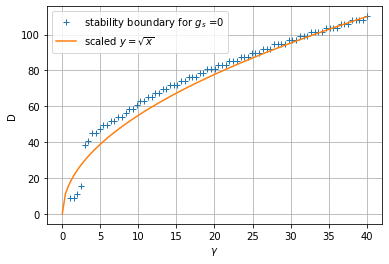

In [17]:

gamma_values = np.asarray(method.stability_boundary_gamma_values)
D_values = np.asarray(method.stability_boundary_D_values)
#####need to get data from paper that equates to the purely dipolar case
a = 110/np.sqrt(40)
x = np.linspace(0,40,100)
y = a*np.sqrt(x)
plt.plot(gamma_values,D_values,'+',label= 'stability boundary for $g_{s}$ ='+str(0))
plt.plot(x,y,label = 'scaled $y=\sqrt{x}$')
plt.xlabel('$\gamma$')
plt.ylabel('D')
plt.grid()
plt.legend()
#plt.xlim(0,self.nu_range)
#plt.ylim(0,self.nu_d_range)
plt.show()


In [12]:
nu_values = method.stability_boundary_nu_values
nu_d_values = method.stability_boundary_nu_dipole_values
nu_values = np.asarray(nu_values)
nu_d_values = np.asarray(nu_d_values)
nu_and_nu_d_data = pd.read_csv("C:\\Users\\david\\Documents\\data for fig5b from flattened BEC paper.csv", header = None)
nu_and_nu_d_data = nu_and_nu_d_data.values

plt.plot(nu_values,nu_d_values,'+',label= 'stability boundary for gamma ='+str(method.gamma))
plt.plot(nu_and_nu_d_data[0,:],nu_and_nu_d_data[1,:],label = 'data from paper')

plt.xlabel('nu')
plt.ylabel('nu_d')
plt.grid()
plt.legend()
plt.xlim(0,self.nu_range)
plt.ylim(0,self.nu_d_range)
plt.show()

AttributeError: 'split_step_method' object has no attribute 'stability_boundary_nu_values'

10.0

In [218]:
# D_range = 180
# gamma_range = 17
# D_res = 11
# gamma_res=9
# Ds = np.linspace(0,D_range,D_res)
# gammas = np.linspace(1,gamma_range,gamma_res)
# df = pd.DataFrame(np.rot90(self.stability_matrix),index = np.max(Ds)-Ds,columns=gammas)
# sns.heatmap(df)
# plt.xlabel('$\gamma$')
# plt.ylabel('D')
# plt.show() 


Text(0.5, 0, '$\nu$')

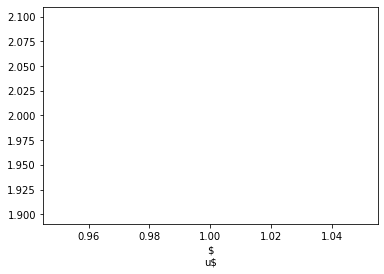

In [268]:
# plt.plot(np.asarray(nu_values),np.asarray(nu_d_values), label= "points on stability boundary")
# plt.xlabel('$\nu$')
# plt.xlabel('$\nu_{d}$')
plt.plot(1,2)
plt.xlabel('$\nu$')

In [406]:
print(method.stability_boundary_nu_values)
method.stability_boundary_nu_dipole_values

[0.0, 0.25316455696202533, 0.25316455696202533, 0.5063291139240507, 0.5063291139240507, 0.759493670886076, 1.0126582278481013, 1.0126582278481013, 1.2658227848101267, 1.518987341772152, 1.7721518987341773, 1.7721518987341773, 2.0253164556962027, 2.278481012658228, 2.5316455696202533, 2.7848101265822787, 3.037974683544304, 3.2911392405063293, 3.5443037974683547, 3.79746835443038]


[0.0,
 0.10526315789473684,
 0.21052631578947367,
 0.3157894736842105,
 0.42105263157894735,
 0.5263157894736842,
 0.631578947368421,
 0.7368421052631579,
 0.8421052631578947,
 0.9473684210526315,
 1.0526315789473684,
 1.1578947368421053,
 1.263157894736842,
 1.3684210526315788,
 1.4736842105263157,
 1.5789473684210527,
 1.6842105263157894,
 1.789473684210526,
 1.894736842105263,
 2.0]

In [408]:
np.linspace(0,3,81)

array([0.    , 0.0375, 0.075 , 0.1125, 0.15  , 0.1875, 0.225 , 0.2625,
       0.3   , 0.3375, 0.375 , 0.4125, 0.45  , 0.4875, 0.525 , 0.5625,
       0.6   , 0.6375, 0.675 , 0.7125, 0.75  , 0.7875, 0.825 , 0.8625,
       0.9   , 0.9375, 0.975 , 1.0125, 1.05  , 1.0875, 1.125 , 1.1625,
       1.2   , 1.2375, 1.275 , 1.3125, 1.35  , 1.3875, 1.425 , 1.4625,
       1.5   , 1.5375, 1.575 , 1.6125, 1.65  , 1.6875, 1.725 , 1.7625,
       1.8   , 1.8375, 1.875 , 1.9125, 1.95  , 1.9875, 2.025 , 2.0625,
       2.1   , 2.1375, 2.175 , 2.2125, 2.25  , 2.2875, 2.325 , 2.3625,
       2.4   , 2.4375, 2.475 , 2.5125, 2.55  , 2.5875, 2.625 , 2.6625,
       2.7   , 2.7375, 2.775 , 2.8125, 2.85  , 2.8875, 2.925 , 2.9625,
       3.    ])